<a href="https://colab.research.google.com/github/GonzaloMA-17/k_brazos_FJLGM/blob/main/notebook1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Asignatura**: Extensiones de Machine Learning, 2024/2025

**Alumnos**:<br>
- Gonzalo Marcos Andrés (gonzalo.marcosa@um.es)
- Francisco José López Fernández (franciscojose.lopezf@um.es)

**Máster de Inteligencia Artificial**

| **Facultad de Informática** | **Universidad de Murcia** |
|-----------------------------|---------------------------|
| ![](https://www.um.es/image/layout_set_logo?img_id=175281&t=1726728636242) | ![](https://www.um.es/o/um-lr-principal-um-home-theme/images/logo-um.png) |

# Estudio comparativo de algoritmos en un problema de bandido de k-brazos

### Resolución del Problema con Algoritmos Softmax

En este estudio, abordaremos el problema del bandido de k-brazos utilizando algoritmos Softmax. Este enfoque es una alternativa a los algoritmos epsilon-greedy y se basa en la probabilidad de seleccionar cada brazo en función de su valor estimado.

#### Algoritmos Softmax

A diferencia de los algoritmos epsilon-greedy, que seleccionan el mejor brazo conocido con una alta probabilidad y exploran otros brazos con una pequeña probabilidad, los algoritmos Softmax asignan una probabilidad a cada brazo basada en su valor estimado. Esto permite una exploración más equilibrada y puede mejorar el rendimiento en ciertos escenarios.

#### Objetivos del Estudio

En este estudio, compararemos el rendimiento de diferentes configuraciones del algoritmo Softmax en un entorno de bandido de 10 brazos. Para ello, realizaremos múltiples ejecuciones del experimento y generaremos las siguientes gráficas:

1. **Porcentaje de Selección del Brazo**: Mostraremos cómo varía el porcentaje de veces que cada brazo es seleccionado a lo largo del tiempo.
2. **Estadísticas de Cada Brazo**: Presentaremos el promedio de las ganancias obtenidas por cada brazo, lo que nos permitirá evaluar la efectividad de las selecciones.
3. **Evolución del Rechazo**: Analizaremos cómo evoluciona el rechazo acumulado (diferencia entre la recompensa óptima y la recompensa obtenida) a lo largo del tiempo.

Estas visualizaciones nos permitirán entender mejor el comportamiento de los algoritmos Softmax y su capacidad para equilibrar la exploración y la explotación en el problema del bandido de k-brazos.


## Preparación del entorno

**Clonación del repositorio:**

Para poder acceder a todas las clases y métodos necesarios.

In [ ]:
!git clone https://github.com/GonzaloMA-17/k_brazos_FJLGM.git

In [ ]:
%cd k_brazos_FJLGM

### Librerías

In [ ]:
!pip install -r requirements.txt

In [2]:
import numpy as np
from typing import List

from src_algorithms import Algorithm, Softmax, GradientPreference
from src_arms import *
from src_plotting import *

Semilla:

In [3]:
seed = 1234

**Definición del experimento:**

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado. Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan dos algoritmos Softmax con diferentes valores de temperatura. Se estudia la evolución de cada política en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recompensas obtenidas en esas 500 veces.

In [4]:
def run_experiment_complete(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):
    optimal_arm = bandit.optimal_arm
    optimal_reward = bandit.arms[optimal_arm].get_expected_value()  # Obtener la recompensa esperada del brazo óptimo

    rewards = np.zeros((len(algorithms), steps))  # Matriz para almacenar las recompensas promedio.
    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.
    arm_rewards = np.zeros((len(algorithms), bandit.k))  # Matriz para almacenar las recompensas acumuladas por brazo.
    arm_counts = np.zeros((len(algorithms), bandit.k))  # Matriz para almacenar el número de selecciones por brazo.
    selections_per_algorithm = np.zeros((len(algorithms), bandit.k))  # Matriz para contar selecciones por brazo.
    regret_accumulated = np.zeros((len(algorithms), steps))  # Matriz para almacenar el rechazo acumulado.

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)

        for algo in algorithms:
            algo.reset()  # Reiniciar los valores de los algoritmos.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm()  # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm)  # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward)  # Actualizar el valor estimado del brazo seleccionado.

                rewards[idx, step] += reward  # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                selections_per_algorithm[idx, chosen_arm] += 1

                arm_rewards[idx, chosen_arm] += reward  # Acumular la recompensa obtenida en arm_rewards para el brazo chosen_arm.
                arm_counts[idx, chosen_arm] += 1  # Incrementar el conteo de selecciones para el brazo chosen_arm.

                # Modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

                # Calcular el rechazo acumulado
                regret_accumulated[idx, step] += optimal_reward - reward

    rewards /= runs

    # Calcular el porcentaje de selecciones óptimas y almacenar en optimal_selections
    optimal_selections = (optimal_selections / runs) * 100

    # Calcular el promedio de ganancias de cada brazo
    average_rewards = arm_rewards / np.maximum(arm_counts, 1)

    # Calcular el rechazo acumulado promedio
    regret_accumulated = np.cumsum(regret_accumulated, axis=1) / runs

    # Preparar las estadísticas de los brazos
    arm_stats = [{'average_rewards': average_rewards[idx], 'selection_counts': arm_counts[idx]} for idx in range(len(algorithms))]

    return rewards, optimal_selections, arm_stats, regret_accumulated

**Ejecución del experimento**:

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución Binomial con parámetros **n y p**. 

Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan dos algoritmos de la familia de **Ascenso del gradiente**: 

- *Softmax*
- *Gradiente de preferencias*.

In [5]:
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
algorithms = [Softmax(k=k, tau=0.1),Softmax(k=k, tau=1), GradientPreference(k=k, alpha=0.1), GradientPreference(k=k, alpha=0.5)]

rewards, optimal_selections, arm_stats, regret_accumulated = run_experiment_complete(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmNormal(mu=2.72, sigma=1.0), ArmNormal(mu=3.45, sigma=1.0), ArmNormal(mu=4.94, sigma=1.0), ArmNormal(mu=3.49, sigma=1.0), ArmNormal(mu=6.6, sigma=1.0), ArmNormal(mu=8.07, sigma=1.0), ArmNormal(mu=8.02, sigma=1.0), ArmNormal(mu=8.22, sigma=1.0), ArmNormal(mu=9.62, sigma=1.0), ArmNormal(mu=8.88, sigma=1.0)
Optimal arm: 9 with expected reward=9.62


**Visualización de resultados**:

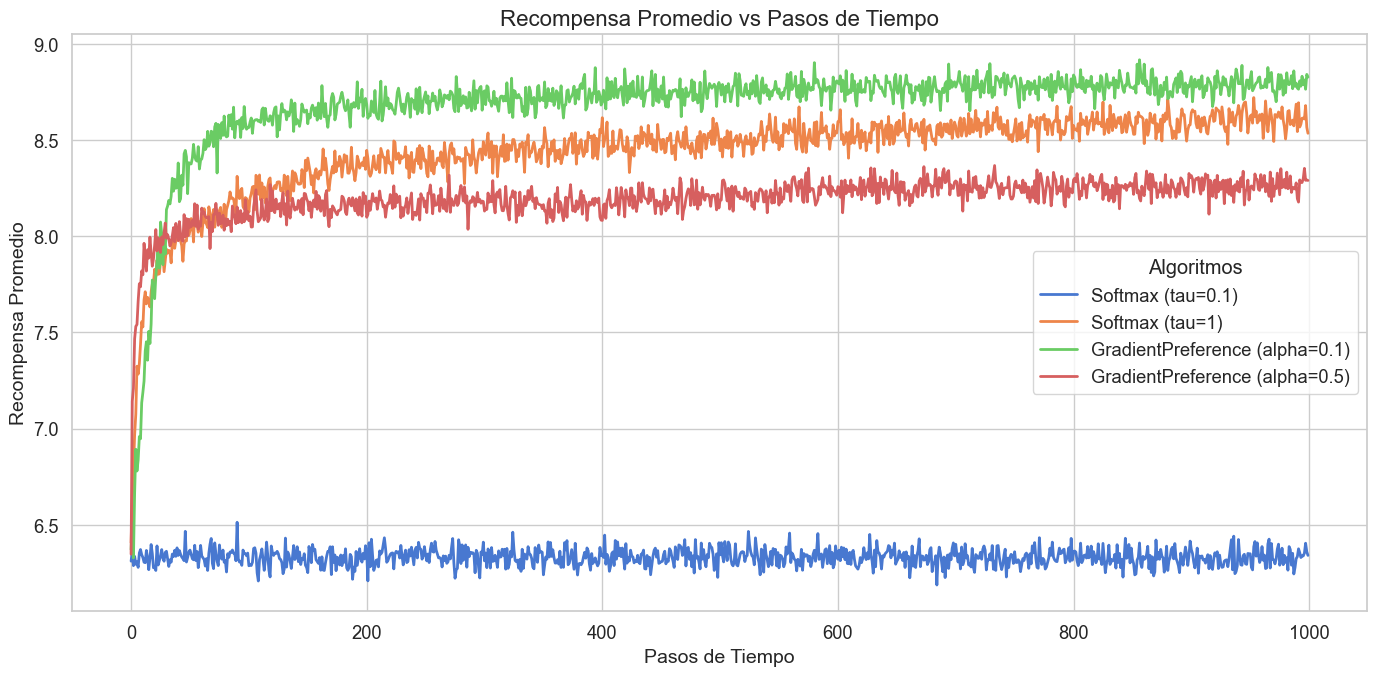

In [6]:
# Graficar los resultados
plot_average_rewards(steps, rewards, algorithms)
# plot_optimal_selections(steps, optimal_selections, algorithms)

**Análisis de la Recompensa Promedio en Función del Tiempo**

**Descripción de los Algoritmos y Configuraciones:**

- Softmax (τ = 0.1) - Azul: Baja exploración, favorece la explotación temprana.

- Softmax (τ = 1) - Naranja: Mayor exploración, lo que permite evaluar más opciones antes de explotar.

- Gradiente de Preferencias (α = 0.1) - Verde: Tasa de aprendizaje baja, lo que permite un ajuste gradual y estable de las preferencias.

- Gradiente de Preferencias (α = 0.5) - Rojo: Tasa de aprendizaje alta, lo que permite una adaptación rápida pero puede llevar a convergencia prematura en una política subóptima.

**Análisis de Resultados**

1. Crecimiento y Convergencia de la Recompensa Promedio

- El Gradiente de Preferencias con α = 0.1 (verde) obtiene la mejor recompensa promedio final. Su menor tasa de aprendizaje permite una convergencia más estable y efectiva hacia los brazos óptimos.

- El Gradiente de Preferencias con α = 0.5 (rojo) converge más rápido pero alcanza una recompensa menor. Su mayor tasa de aprendizaje ajusta las preferencias rápidamente, pero puede llevar a decisiones precipitadas sin explorar suficientemente todas las opciones.

- Softmax con τ = 1 (naranja) obtiene una recompensa promedio mayor que Softmax con τ = 0.1 (azul). La mayor exploración inicial de τ = 1 le permite evitar caer en elecciones subóptimas, pero no logra alcanzar la recompensa final del Gradiente de Preferencias con α = 0.1.

2. Equilibrio entre Exploración y Explotación

- Gradiente de Preferencias ajusta dinámicamente las probabilidades de selección de los brazos, lo que resulta en un mejor desempeño.
- Softmax utiliza una estrategia de exploración controlada por temperatura (τ), pero su rendimiento es inferior al de Gradiente de Preferencias en este experimento.

**Conclusiones**

- El mejor desempeño se obtuvo con Gradiente de Preferencias (α = 0.1), que logró la mayor recompensa promedio.

- Un α más alto (como 0.5) puede llevar a una convergencia rápida pero subóptima.

- Softmax con una temperatura mayor (τ = 1) supera a τ = 0.1, pero no es tan eficiente como Gradiente de Preferencias.

- Un buen balance entre exploración y explotación es clave para maximizar la recompensa a largo plazo.


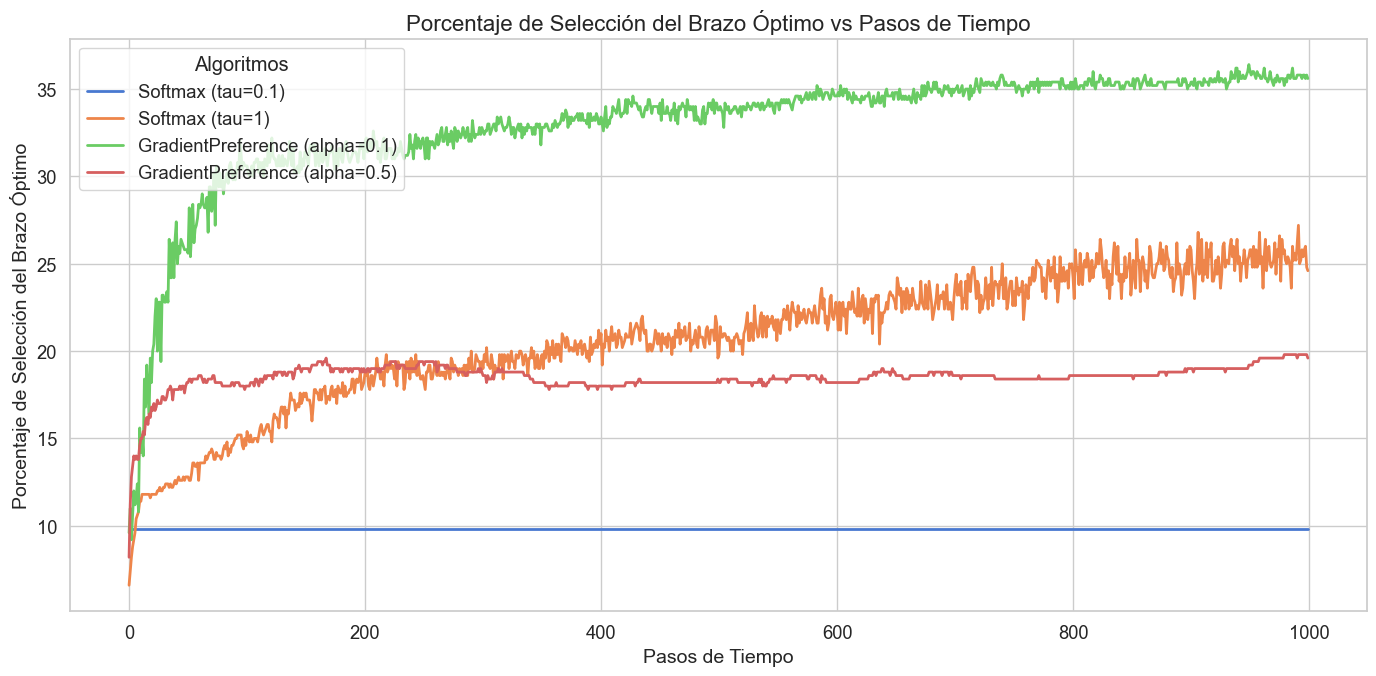

In [7]:
plot_optimal_selections(steps, optimal_selections, algorithms)

**Explicación de los Resultados: Porcentaje de Selección del Brazo Óptimo**

En la gráfica de porcentaje de selección del brazo óptimo, se observa cómo cada algoritmo selecciona el brazo con la mayor recompensa esperada a lo largo del tiempo. A continuación, se detallan los resultados obtenidos para cada configuración de los algoritmos:

- **Azul (Softmax, τ = 0.1)**:
    - Este algoritmo muestra una tendencia a seleccionar el brazo óptimo con una frecuencia constante a lo largo del tiempo. Debido a la menor exploración (τ = 0.1), no logra identificar el brazo óptimo de manera eficiente en comparación con configuraciones con mayor exploración.

- **Naranja (Softmax, τ = 1)**:
    - Con una mayor temperatura (τ = 1), este algoritmo explora más al principio, lo que le permite identificar el brazo óptimo más rápidamente. Como resultado, el porcentaje de selección del brazo óptimo aumenta más rápidamente en comparación con τ = 0.1.

- **Verde (Gradiente de Preferencias, α = 0.1)**:
    - Este algoritmo ajusta sus preferencias de manera más lenta debido a la menor tasa de aprendizaje (α = 0.1). Aunque eventualmente converge a seleccionar el brazo óptimo con mayor frecuencia, lo hace a un ritmo más lento que el Gradiente de Preferencias con α = 0.5.

- **Rojo (Gradiente de Preferencias, α = 0.5)**:
    - Con una tasa de aprendizaje más alta (α = 0.5), este algoritmo ajusta sus preferencias rápidamente, lo que le permite identificar y seleccionar el brazo óptimo con mayor frecuencia desde etapas tempranas del experimento. Esto se refleja en un rápido aumento en el porcentaje de selección del brazo óptimo.


### Arrepentimiento acumulado:

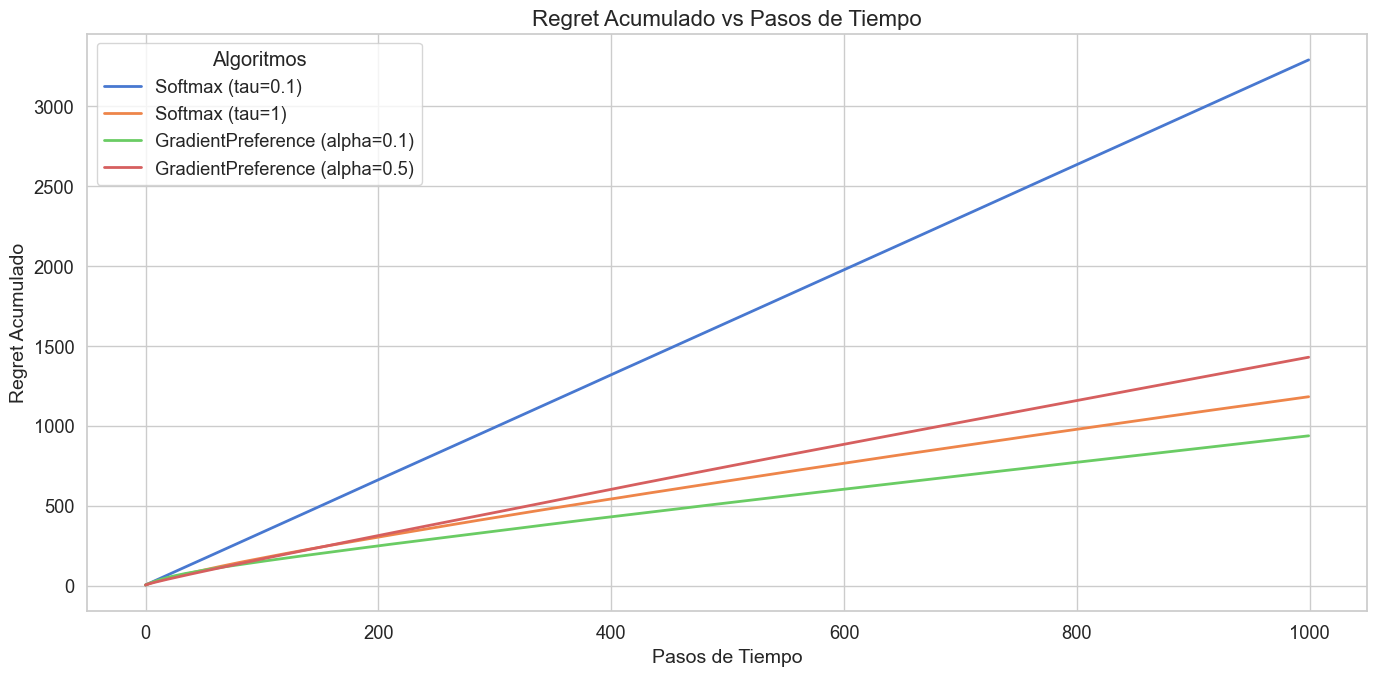

In [8]:
plot_regret(steps, regret_accumulated, algorithms)

- El algoritmo Softmax con tau=0.1 tiene el mayor regret acumulado, lo que indica que es el menos eficiente de los cuatro algoritmos en minimizar el regret a lo largo del tiempo. Puede deberse a que tiende a explotar demasiado los brazos inicialmente considerados como buenos, lo que puede llevar a subóptimas elecciones si esos brazos no son realmente los mejores.

- El algoritmo GradientPreference con alpha=0.1 tiene el menor regret acumulado, lo que sugiere que es el más eficiente en minimizar el regret en este contexto. Lo que nos sugiere que una política de ajuste más conservadora puede ser efectiva para seleccionar brazos óptimos en un contexto de brazos gaussianos.

- El algoritmo Softmax con tau=1 y el algoritmo GradientPreference con alpha=0.5 tienen un rendimiento intermedio, con el algoritmo GradientPreference (alpha=0.5) siendo ligeramente mejor que el Softmax (tau=1).


### Conclusiones:

1. **Exploración vs Explotación**:
     - Los algoritmos con mayor exploración inicial (Softmax con τ = 1 y Gradiente de Preferencias con α = 0.5) identifican el brazo óptimo más rápidamente y, por lo tanto, muestran un aumento más rápido en el porcentaje de selección del brazo óptimo.
     - Los algoritmos con menor exploración (Softmax con τ = 0.1 y Gradiente de Preferencias con α = 0.1) tardan más en identificar el brazo óptimo, lo que se refleja en un aumento más lento en el porcentaje de selección del brazo óptimo.

2. **Convergencia**:
     - Todos los algoritmos eventualmente convergen a seleccionar el brazo óptimo con alta frecuencia, pero la velocidad de convergencia varía según el grado de exploración y la tasa de aprendizaje.
     - El Gradiente de Preferencias con α = 0.5 muestra la convergencia más rápida, seguido por Softmax con τ = 1, Gradiente de Preferencias con α = 0.1 y finalmente Softmax con τ = 0.1.

3. **Rendimiento General**:
     - El Gradiente de Preferencias con α = 0.1 obtiene la mejor recompensa promedio final, lo que indica que una tasa de aprendizaje más baja permite una convergencia más estable y efectiva hacia los brazos óptimos.
     - El Gradiente de Preferencias con α = 0.5 converge más rápido pero alcanza una recompensa menor debido a decisiones precipitadas sin explorar suficientemente todas las opciones.
     - Softmax con τ = 1 obtiene una recompensa promedio mayor que Softmax con τ = 0.1, pero no logra alcanzar la recompensa final del Gradiente de Preferencias con α = 0.1.

4. **Aplicaciones Prácticas**:
     - En aplicaciones donde es crucial identificar rápidamente la mejor opción (por ejemplo, recomendaciones personalizadas, optimización de anuncios), los algoritmos con mayor exploración inicial y rápida adaptación (como Gradiente de Preferencias con α = 0.5) son más efectivos.
     - Un balance adecuado entre exploración y explotación es esencial para maximizar la recompensa a largo plazo y asegurar que el algoritmo no se quede atrapado en una elección subóptima.

**Algoritmo Ganador**: El Gradiente de Preferencias con α = 0.1 es el algoritmo ganador, ya que logra la mayor recompensa promedio final y minimiza el arrepentimiento acumulado.